In [10]:
!pip install imblearn

In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [35]:
df_final = pd.read_csv('../01_data/clean/df_final.csv')
df_final

,age,time_in_hospital,n_lab_procedures,primary_diagnosis,readmitted
0,(70-80),8,72,Circulatory,0
1,(70-80),3,34,Other,0
2,(50-60),5,45,Circulatory,1
3,(70-80),2,36,Circulatory,1
4,(60-70),1,42,Other,0
...,...,...,...,...,...
24995,(80-90),14,77,Circulatory,1
24996,(80-90),2,66,Digestive,1
24997,(70-80),5,12,Other,1
24998,(70-80),2,61,Respiratory,0


In [36]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   primary_diagnosis  25000 non-null  object
 4   readmitted         25000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 976.7+ KB


In [37]:
df_final.isnull().sum()

age                  0
time_in_hospital     0
n_lab_procedures     0
primary_diagnosis    0
readmitted           0
dtype: int64

In [38]:
df_final.dtypes

age                  object
time_in_hospital      int64
n_lab_procedures      int64
primary_diagnosis    object
readmitted            int64
dtype: object

Categorical and Numerical Variables (Encoding & Scaling)

In [39]:
df_final

,age,time_in_hospital,n_lab_procedures,primary_diagnosis,readmitted
0,(70-80),8,72,Circulatory,0
1,(70-80),3,34,Other,0
2,(50-60),5,45,Circulatory,1
3,(70-80),2,36,Circulatory,1
4,(60-70),1,42,Other,0
...,...,...,...,...,...
24995,(80-90),14,77,Circulatory,1
24996,(80-90),2,66,Digestive,1
24997,(70-80),5,12,Other,1
24998,(70-80),2,61,Respiratory,0


In [45]:
df_final['age'].value_counts()

age
(70-80)     6837
(60-70)     5913
(80-90)     4516
(50-60)     4452
(40-50)     2532
(90-100)     750
Name: count, dtype: int64

In [52]:
#Encoding age column
df_final['age'] = df_final['age'].str.strip().str.replace('(', '[').str.replace(')', ']')

# Check for any unique values in the 'age' column to verify the standardization
print("Unique age categories after cleaning:")
print(df_final['age'].unique())

# Define the ordered categories, ensure they match the cleaned 'age' column
age_categories = ['[20-30]', '[30-40]', '[40-50]', '[50-60]', '[60-70]', '[70-80]', '[80-90]', '[90-100]']

# Apply Ordinal Encoding based on the defined categories
ordinal_encoder = OrdinalEncoder(categories=[age_categories])

# Apply the encoding
df_final['age_encoded'] = ordinal_encoder.fit_transform(df_final[['age']])

# View the encoded result
print(df_final[['age', 'age_encoded']].head())


Unique age categories after cleaning:
['[70-80]' '[50-60]' '[60-70]' '[40-50]' '[80-90]' '[90-100]']
       age  age_encoded
0  [70-80]          5.0
1  [70-80]          5.0
2  [50-60]          3.0
3  [70-80]          5.0
4  [60-70]          4.0


In [53]:
df_final.dtypes

age                   object
time_in_hospital       int64
n_lab_procedures       int64
primary_diagnosis     object
readmitted             int64
age_encoded          float64
dtype: object

In [90]:
# One-hot encoding for 'primary_diagnosis' 
df_final = pd.get_dummies(df_final, columns=['primary_diagnosis'], drop_first=True)

KeyError: "None of [Index(['primary_diagnosis'], dtype='object')] are in the [columns]"

In [91]:
df_final.columns


Index(['age', 'time_in_hospital', 'n_lab_procedures', 'readmitted',
       'age_encoded', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Digestive', 'primary_diagnosis_Injury',
       'primary_diagnosis_Missing', 'primary_diagnosis_Musculoskeletal',
       'primary_diagnosis_Other', 'primary_diagnosis_Respiratory'],
      dtype='object')

In [92]:
df_final

,age,time_in_hospital,n_lab_procedures,readmitted,age_encoded,primary_diagnosis_Diabetes,primary_diagnosis_Digestive,primary_diagnosis_Injury,primary_diagnosis_Missing,primary_diagnosis_Musculoskeletal,primary_diagnosis_Other,primary_diagnosis_Respiratory
0,[70-80],8,72,0,5.0,False,False,False,False,False,False,False
1,[70-80],3,34,0,5.0,False,False,False,False,False,True,False
2,[50-60],5,45,1,3.0,False,False,False,False,False,False,False
3,[70-80],2,36,1,5.0,False,False,False,False,False,False,False
4,[60-70],1,42,0,4.0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90],14,77,1,6.0,False,False,False,False,False,False,False
24996,[80-90],2,66,1,6.0,False,True,False,False,False,False,False
24997,[70-80],5,12,1,5.0,False,False,False,False,False,True,False
24998,[70-80],2,61,0,5.0,False,False,False,False,False,False,True


Perform Train Test Split

In [62]:
X = df_final.drop(columns=['readmitted', 'age'])  
y = df_final['readmitted'] 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler with pickle in the "scalers/" folder

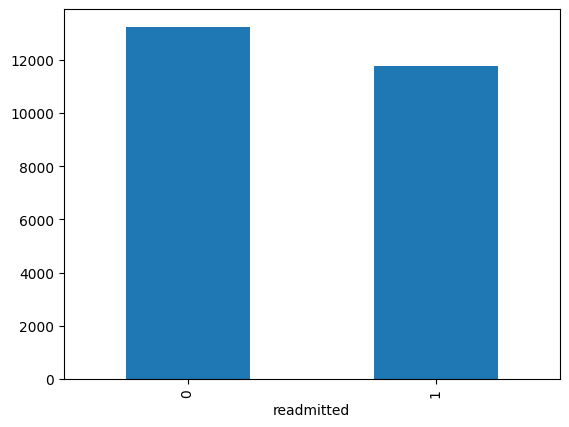

In [94]:
target_column = 'readmitted'  
target_distribution = df_final["readmitted"].value_counts()
target_distribution.plot(kind="bar")
plt.show()

Oversampling

In [115]:
train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
train["readmitted"] = y_train.values
readmitted = train[train["readmitted"] == 1]
readmitted_no= train[train["readmitted"] == 0]

In [116]:
len(readmitted),len(readmitted_no)

(9320, 10680)

In [119]:
yes_oversampled = resample(df_final,replace=True, n_samples = len(readmitted_no), random_state=0)
train_over = pd.concat([yes_oversampled, readmitted_no])
train_over

,age,time_in_hospital,n_lab_procedures,readmitted,age_encoded,primary_diagnosis_Diabetes,primary_diagnosis_Digestive,primary_diagnosis_Injury,primary_diagnosis_Missing,primary_diagnosis_Musculoskeletal,primary_diagnosis_Other,primary_diagnosis_Respiratory
2732,[80-90],2.000000,53.000000,0,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10799,[60-70],7.000000,69.000000,0,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,[60-70],2.000000,70.000000,0,4.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19648,[70-80],4.000000,57.000000,1,5.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13123,[50-60],12.000000,30.000000,0,3.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19992,NaN,-1.155303,-0.822123,0,-1.027008,-0.276348,-0.319072,-0.266365,-0.014144,-0.225892,-0.593981,-0.416371
19995,NaN,2.520654,-0.670246,0,-1.027008,-0.276348,-0.319072,-0.266365,-0.014144,-0.225892,1.683555,-0.416371
19997,NaN,-0.821125,1.354774,0,-0.265810,-0.276348,-0.319072,-0.266365,-0.014144,-0.225892,1.683555,-0.416371
19998,NaN,0.849764,1.304148,0,-0.265810,-0.276348,-0.319072,-0.266365,-0.014144,-0.225892,-0.593981,-0.416371


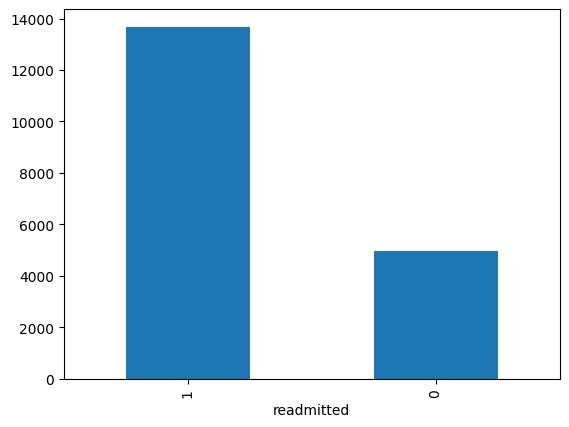

In [118]:
df_final_over_plt = train_over["readmitted"].value_counts()
df_final_over_plt.plot(kind="bar")
plt.show()

Logistic Regression Model - Used this becasue my target variable has binary classification

In [70]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Save the model with pickle in the "models/" folder.

LogisticRegression()

In [71]:
log_reg.score(X_test_scaled, y_test)

0.5214

In [101]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df.head())

       Actual  Predicted
14149       1          0
8946        1          0
22378       1          0
12162       0          0
4879        1          0


In [96]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5198
Confusion Matrix:
 [[1450 1116]
 [1285 1149]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.57      0.55      2566
           1       0.51      0.47      0.49      2434

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



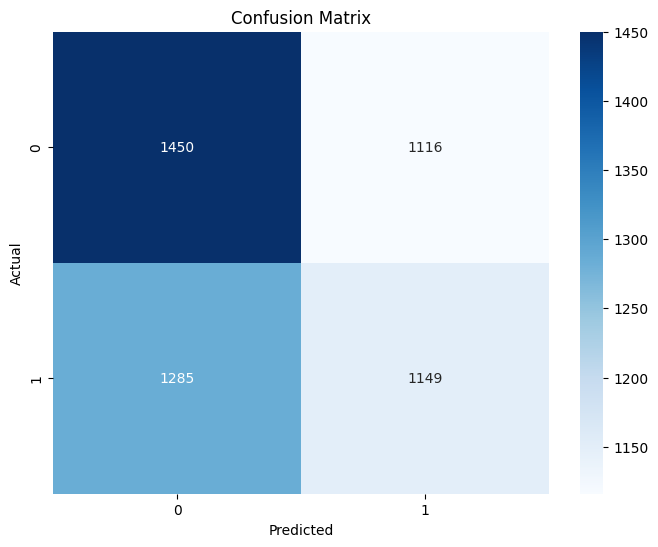

In [98]:
# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5214
Confusion Matrix:
 [[2132  434]
 [1959  475]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.83      0.64      2566
           1       0.52      0.20      0.28      2434

    accuracy                           0.52      5000
   macro avg       0.52      0.51      0.46      5000
weighted avg       0.52      0.52      0.47      5000



Trying Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

# Train a classifier
clf = RandomForestClassifier()
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55      2566
           1       0.51      0.47      0.49      2434

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000

[[1450 1116]
 [1285 1149]]


In [ ]:
# scorer = make_scorer(scoring_function, maximize=True)
# GridSearchCV(scorer=scorer)